# Tutorial pytorch

https://pytorch-lightning.readthedocs.io/en/stable/starter/introduction.html

In [21]:
import os
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve,\
roc_auc_score

In [22]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, latent_space_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, latent_space_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_space_dim, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        output = self.decoder(embedding)
        return output

    def forward_embedding(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        return embedding

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [23]:
# import dataset
dataset = MNIST(os.getcwd(), download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=10)

# init model
latent_space_dim = 15
autoencoder = LitAutoEncoder(latent_space_dim)

In [5]:
# train the model

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
# trainer = pl.Trainer(accelerator="gpu", devices=8) (if you have GPUs)
trainer = pl.Trainer(max_epochs=1)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 51.2 K
1 | decoder | Sequential | 52.0 K
---------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     To

Training: 0it [00:00, ?it/s]

In [6]:
get_X_y_loader = DataLoader(dataset, batch_size=60000)

X,Y = list(get_X_y_loader)[0]

X.shape

torch.Size([60000, 1, 28, 28])

In [7]:
i = 230

outputs = autoencoder.forward(X[i].flatten())
outputs = outputs.reshape(28,28)

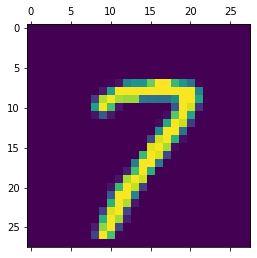

<Figure size 432x288 with 0 Axes>

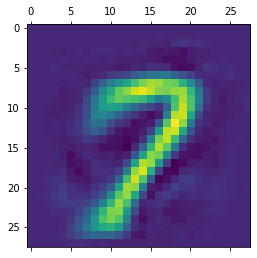

In [8]:
plt.matshow(X[i][0])
plt.figure()
plt.matshow(outputs.detach().numpy())

In [9]:
autoencoder.forward_embedding(X[:10].flatten(start_dim=1))

tensor([[-0.1451,  0.4071, -0.1414, -0.5115, -0.3112,  0.1048, -0.6085,  1.0817,
          0.4114,  0.2532,  1.3883, -1.2937, -0.9001,  0.4669, -0.6296],
        [-0.3082,  0.1954,  1.4195, -1.6393, -0.5129,  0.4608, -0.4463, -0.0473,
         -1.6607, -0.0989,  2.1451, -2.1447, -0.2214, -0.3113, -1.0416],
        [ 0.5421, -0.5779,  0.3321,  0.4336, -0.7860,  1.5834, -0.7857,  0.2791,
         -0.6690,  0.4184,  1.0873,  0.8694,  0.2971,  0.4749, -0.4133],
        [ 0.6593,  1.1012,  0.0329, -0.7978, -0.4490, -1.0858, -0.9697,  0.2747,
         -0.3702,  1.0820, -0.7492, -0.6860,  0.7247,  0.7379, -0.0405],
        [ 1.5528,  0.9656, -0.4108, -0.2011,  0.0325,  1.0843, -0.9245, -0.8705,
          0.6207,  0.5341,  0.4353,  0.1880,  0.8525,  0.1990, -1.2704],
        [-0.2546, -0.5055, -0.3217, -0.9141,  0.1953, -0.0766, -1.4160,  0.2664,
         -0.5521,  0.5213,  2.4485, -0.5218,  0.7170,  0.7340, -0.2391],
        [ 0.0423, -0.6327, -1.3651, -0.2742,  0.6104, -0.2256,  0.6618, -0.2

## add classifier

In [10]:
class LinearClassifier(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer0 = nn.Linear(input_size, output_size)
        self.activation0 = nn.Softmax(dim=1)
        self.loss = nn.CrossEntropyLoss()
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        output = self.layer0(x)
        output = self.activation0(output)
        return output
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        #x = x.view(x.size(0), -1)
        output = self.forward(x)
        loss = self.loss(output, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [11]:
# define the linear classifier
lin_class = LinearClassifier(latent_space_dim, 10)

In [12]:
# create its dataset
X_propag = X.flatten(start_dim=1)
embeddings = autoencoder.forward_embedding(X_propag)
embeddings.detach_()
print(embeddings[:10])

# apparently no need
Y_one_hot = F.one_hot(Y).type(torch.FloatTensor)
print(Y_one_hot[:5])

tensor([[-0.1451,  0.4071, -0.1414, -0.5115, -0.3112,  0.1048, -0.6085,  1.0817,
          0.4114,  0.2532,  1.3883, -1.2937, -0.9001,  0.4669, -0.6296],
        [-0.3082,  0.1954,  1.4195, -1.6393, -0.5129,  0.4608, -0.4463, -0.0473,
         -1.6607, -0.0989,  2.1451, -2.1447, -0.2214, -0.3113, -1.0416],
        [ 0.5421, -0.5779,  0.3321,  0.4336, -0.7860,  1.5834, -0.7857,  0.2791,
         -0.6690,  0.4184,  1.0873,  0.8694,  0.2971,  0.4749, -0.4133],
        [ 0.6593,  1.1012,  0.0329, -0.7978, -0.4490, -1.0858, -0.9697,  0.2747,
         -0.3702,  1.0820, -0.7492, -0.6860,  0.7247,  0.7379, -0.0405],
        [ 1.5528,  0.9656, -0.4108, -0.2011,  0.0325,  1.0843, -0.9245, -0.8705,
          0.6207,  0.5341,  0.4353,  0.1880,  0.8525,  0.1990, -1.2704],
        [-0.2546, -0.5055, -0.3217, -0.9141,  0.1953, -0.0766, -1.4160,  0.2664,
         -0.5521,  0.5213,  2.4485, -0.5218,  0.7170,  0.7340, -0.2391],
        [ 0.0423, -0.6327, -1.3651, -0.2742,  0.6104, -0.2256,  0.6618, -0.2

In [13]:
# train the linear classifier on the latent space embedding

train_set = TensorDataset(embeddings, Y)
train_loader_lin = DataLoader(train_set, batch_size=10)

trainer_lin = pl.Trainer(max_epochs=5)
trainer_lin.fit(model=lin_class, train_dataloaders=train_loader_lin)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type             | Params
-------------------------------------------------
0 | layer0      | Linear           | 160   
1 | activation0 | Softmax          | 0     
2 | loss        | CrossEntropyLoss | 0     
-------------------------------------------------
160       Trainable params
0         Non-trainable params
160       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [14]:
Y_pred = lin_class.forward(embeddings)
Y_pred = pd.DataFrame(Y_pred.detach().numpy())
Y_pred["prediction"] = Y_pred.apply(np.argmax, axis=1)
Y_pred

,0,1,2,3,4,5,6,7,8,9,prediction
0,5.009928e-03,7.469503e-06,1.242133e-02,5.613064e-01,1.004791e-07,0.396970,2.022694e-04,4.241157e-03,1.822945e-02,1.611490e-03,3
1,9.990822e-01,2.948407e-16,1.438319e-11,1.364113e-11,6.809391e-13,0.000918,1.329700e-08,1.075142e-10,3.041454e-09,1.223539e-11,0
2,8.984737e-05,4.445837e-11,1.486989e-06,3.889900e-04,6.483795e-01,0.000393,4.275278e-06,1.129403e-03,2.429402e-05,3.495889e-01,4
3,5.455174e-07,9.844857e-01,9.453045e-04,7.356701e-06,7.178605e-06,0.000150,3.769938e-05,4.704677e-05,1.431262e-02,6.472946e-06,1
4,1.702829e-09,1.626378e-07,1.095382e-10,8.777641e-10,1.203708e-01,0.000023,5.207037e-08,1.292489e-03,1.292204e-05,8.783007e-01,9
...,...,...,...,...,...,...,...,...,...,...,...
59995,1.620305e-05,9.555512e-05,7.779575e-04,3.633918e-04,4.700170e-07,0.000950,2.369462e-07,3.091300e-08,9.977885e-01,8.100626e-06,8
59996,1.977301e-06,1.006029e-09,6.982867e-05,9.998166e-01,1.563408e-08,0.000101,5.614891e-10,2.345672e-10,1.027183e-05,1.809892e-07,3
59997,2.457090e-04,3.030905e-06,8.145264e-09,1.969892e-04,1.911397e-06,0.996834,2.562465e-08,3.228659e-06,9.674278e-04,1.748055e-03,5
59998,1.184250e-01,2.197596e-07,1.836366e-03,1.010854e-05,9.749688e-04,0.079424,7.993060e-01,4.331422e-07,7.809691e-06,1.537675e-05,6


0.8596


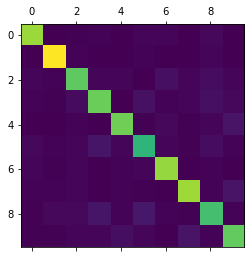

In [15]:
print(accuracy_score(Y, Y_pred.prediction))
conf_mat = confusion_matrix(Y, Y_pred.prediction)
plt.matshow(conf_mat)

## Get the embeddings

In [25]:
# because the embeddings are not calculated through Visualization, each element is present twice
dir_path = '/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/Output/2022-05-18/11-00-10'

train_embeddings = pd.read_csv(dir_path+'/train_embeddings.csv', index_col=0)
val_embeddings = pd.read_csv(dir_path+'/val_embeddings.csv', index_col=0)

print(train_embeddings.shape)
print(val_embeddings.shape)


embeddings = pd.concat([train_embeddings, val_embeddings], axis=0, ignore_index=True)
embeddings

(990, 5)
(110, 5)


,ID,dim1,dim2,dim3,dim4
0,168139,8.607004,10.544548,-1.875861,14.947199
1,168139,6.774639,9.453935,-2.074166,12.493588
2,251833,6.245407,2.204583,-9.917317,2.996176
3,251833,8.898745,3.464000,-8.458150,6.950223
4,121719,8.805327,2.511324,-8.323596,8.753686
...,...,...,...,...,...
1095,618952,2.615529,-3.292192,-12.578430,1.889788
1096,189349,3.607781,-3.065661,-8.625574,9.827278
1097,189349,3.794838,-2.817605,-8.389682,10.302524
1098,140925,9.012708,0.697612,-9.146828,9.339451


In [26]:
embeddings.loc[:, embeddings.columns != 'ID']

,dim1,dim2,dim3,dim4
0,8.607004,10.544548,-1.875861,14.947199
1,6.774639,9.453935,-2.074166,12.493588
2,6.245407,2.204583,-9.917317,2.996176
3,8.898745,3.464000,-8.458150,6.950223
4,8.805327,2.511324,-8.323596,8.753686
...,...,...,...,...
1095,2.615529,-3.292192,-12.578430,1.889788
1096,3.607781,-3.065661,-8.625574,9.827278
1097,3.794838,-2.817605,-8.389682,10.302524
1098,9.012708,0.697612,-9.146828,9.339451


In [27]:
# take the mean of the two representations
embeddings = embeddings.groupby(['ID']).mean()
embeddings

,dim1,dim2,dim3,dim4
ID,,,,
100307,4.518542,-1.731114,-10.004573,5.222970
100610,14.314068,8.940447,-3.657568,18.687688
101107,10.880040,3.124564,-7.629962,10.815388
101309,0.802435,-5.053474,-11.944574,2.161026
102008,9.271605,0.505080,-8.369234,9.781714
...,...,...,...,...
973770,9.259984,4.759903,-3.897219,17.227477
987074,14.558414,7.464320,-4.294970,19.736421
987983,0.022700,-4.455080,-13.534734,-1.307830


In [55]:
# create and save fake labels to test train_classifier
dir_path = "/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/\
Output/2022-05-18/11-00-10/"  # should be passed as an argument/ in config
train_embeddings = pd.read_csv(dir_path+'train_embeddings.csv', index_col=0)
val_embeddings = pd.read_csv(dir_path+'val_embeddings.csv', index_col=0)

embeddings = pd.concat([train_embeddings, val_embeddings],#, test_embeddings],
                        axis=0, ignore_index=True)
embeddings.sort_values(by='ID', inplace=True)

ids = embeddings.ID.values

labels = pd.DataFrame({'ID': ids,
                       'label': np.random.randint(0,2,len(ids))})
labels.to_csv("fake_labels.csv", index=False)

In [28]:
# generate fake labels

labels = np.random.randint(0,2,550)
labels = torch.from_numpy(labels).type(torch.FloatTensor)
print(labels[:10])

# change dtype of embeddings for the next cells to work
embeddings = torch.from_numpy(embeddings.values).type(torch.FloatTensor)
embeddings

tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0.])


tensor([[  4.5185,  -1.7311, -10.0046,   5.2230],
        [ 14.3141,   8.9404,  -3.6576,  18.6877],
        [ 10.8800,   3.1246,  -7.6300,  10.8154],
        ...,
        [  0.0227,  -4.4551, -13.5347,  -1.3078],
        [ 14.1236,   6.5397,  -5.1658,  17.4181],
        [  9.2670,  11.2988,  -2.4796,  14.4740]])

In [39]:
# create classifier

class BinaryClassifier(pl.LightningModule):
    def __init__(self, input_size, output_size, activation=None):
        super().__init__()
        self.layer0 = nn.Linear(input_size, output_size)
        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = None
        self.loss = nn.MSELoss()
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        output = self.layer0(x)
        if self.activation:
            output = self.activation(output)
        return output
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        #x = x.view(x.size(0), -1)
        output = self.forward(x)
        loss = self.loss(output.reshape(y.shape), y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [40]:
bin_class = BinaryClassifier(4,1)

train_set = TensorDataset(embeddings, labels)
train_loader_lin = DataLoader(train_set, batch_size=10)

trainer_lin = pl.Trainer(max_epochs=5)
trainer_lin.fit(model=bin_class, train_dataloaders=train_loader_lin)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type    | Params
-----------------------------------
0 | layer0 | Linear  | 5     
1 | loss   | MSELoss | 0     
-----------------------------------
5         Trainable params
0         Non-trainable params
5         Total params
0.000     Total estimated model params size (MB)
/neurospin/dico/agaudin/Runs/02_explicabilite_humains_2022/2022_jchavas_cingulate_inhibitory_control/venv_local/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

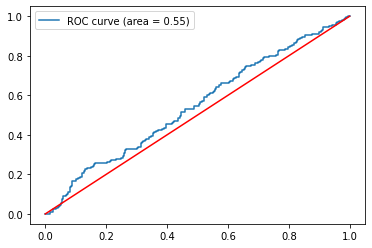

In [41]:
labels_pred = bin_class.forward(embeddings)
labels_pred = labels_pred.detach().numpy()
curves = roc_curve(labels.detach_().numpy(), labels_pred)
roc_auc = roc_auc_score(labels.detach_().numpy(), labels_pred)

plt.plot(curves[0], curves[1], label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1],[0,1],color='r')
plt.legend()

## tests on pd.join 

C'est de la merde, ca met pas les lignes dans le bon ordre, je sais pas pourquoi (ça le fait pour des exemples plus petits). Utiliser sort_values à la place